### Basic Concepts: Nodes, Edges & State

In [1]:
from typing import TypedDict
from langgraph.graph import END, START, StateGraph


class InputState(TypedDict):
    string_value: str
    numeric_value: int


def modify_state(input: InputState):
    print(f"Current value: {input}")
    return input

# set the Graph 
graph = StateGraph(InputState)

# add nodes to graph . and the functionality of the node e.g modify_state.
# meaning each node has a thing to perform. e.g a function call.
graph.add_node("branch_a", modify_state)
graph.add_node("branch_b", modify_state)

# add edges. meaning the order of the execution.
graph.add_edge(START, "branch_a")
# exectue branch_a then branch_b
# also like pipe operator in langchain ,start then its output to =>  node: branch_a 's output is sent to branch_b 
# similar to pipe operator in langchain. 
graph.add_edge("branch_a", "branch_b")
# specify where the execution ends with END.
graph.add_edge("branch_b", END)

# entry point 
graph.set_entry_point("branch_a")

# compile to check nodes and edges are correct are not, 
# unreachale edges .etc. 
runnable = graph.compile()

### Visualize graph

In [ ]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        # gives a png of the graph . 
        runnable.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [2]:
# execute the graph with invoke. 
# prints two times as two  nodes calls the same method modify_state.
runnable.invoke({"string_value": "a"})

Current value: {'string_value': 'a'}
Current value: {'string_value': 'a'}


{'string_value': 'a'}

In [ ]:
runnable.invoke({"string_value": "a", "numeric_value": 1})

In [4]:
def modify_state(input: InputState):
    # actually modifying the dict values.
    input["string_value"] += "a"
    input["numeric_value"] += 1
    return input


graph = StateGraph(InputState)

graph.add_node("branch_a", modify_state)
graph.add_node("branch_b", modify_state)
graph.add_edge("branch_a", "branch_b")
graph.add_edge("branch_b", END)


graph.set_entry_point("branch_a")

runnable = graph.compile()

In [ ]:
try:
    # will throw an error cause numeric_value key is missing.
    runnable.invoke({"string_value": "a"})
except KeyError as e:
    print(e)

In [5]:
runnable.invoke({"string_value": "a", "numeric_value": 1})

{'string_value': 'aaa', 'numeric_value': 3}

### Why not use just LCEL?

In [8]:
from langchain_core.runnables import RunnableLambda

In [9]:
"""
In LangChain, a RunnableLambda is a simple but powerful way to wrap any Python function so it can be used as a building block in LangChain pipelines.
Think of it as an adapter that turns regular Python functions into "LangChain-compatible components" that can be chained together with other LangChain components.

def modify_state(x):
    return x + 5

runnable = RunnableLambda(modify_state)
chain = runnable | runnable  # This will add 5, then add 5 again

result = chain.invoke(10)  # This would return 20 (10 + 5 + 5)

"""



runnable = RunnableLambda(modify_state)

"""
similarly as u can see, we can do the same thing with langchain LCEL style
by piping. here runnable will be executed twice, as in the langGraph too
two nodes execution. ( the same method execution ) . 
but, as in the notes, langchain can get complex in long chains 
there langGraph comes in handy 
but combination of both is used too according to requirements. 
"""


chain = runnable | runnable

In [ ]:
chain.invoke({"string_value": "a", "numeric_value": 1})

### Cycles and Conditional Edges

In [6]:
def modify_state(input: InputState):
    input["string_value"] += "a"
    input["numeric_value"] += 1
    return input


def router(input: InputState):
    if input["numeric_value"] < 5:
        return "branch_a"
    else:
        return "__end__"


graph = StateGraph(InputState)

graph.add_node("branch_a", modify_state)
graph.add_node("branch_b", modify_state)
graph.add_edge("branch_a", "branch_b")

"""
read this as: if router is the conndition 
that returns branch_a then go to branch_a keyed node
else if it returns __end__ then go to END.
"""
graph.add_conditional_edges(
    "branch_b", router, {"branch_a": "branch_a", "__end__": END}
)

graph.set_entry_point("branch_a")

runnable = graph.compile()

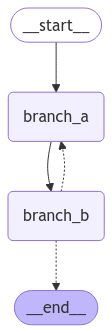

In [7]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        runnable.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [8]:
runnable.invoke({"string_value": "a", "numeric_value": 1})

{'string_value': 'aaaaa', 'numeric_value': 5}

### Reducer functions

In [9]:
from typing import TypedDict, Annotated
from langgraph.graph import END, StateGraph
from operator import add

""" 
Annotated, when states are merged in langGraph
meaning when output of branc_a is sent to branch_b
then the method added to annotated metaData (add)
comes into play, and operates on the input data of 
branch_b.
""" 
class InputState(TypedDict):
    no_change_value: str
    string_value: Annotated[str, add]
    numeric_value: Annotated[int, add]
    list_value: Annotated[list[str], add]


def modify_state(input: InputState):
    return input

In [10]:
graph = StateGraph(InputState)

graph.add_node("branch_a", modify_state)
graph.add_node("branch_b", modify_state)
graph.add_edge("branch_a", "branch_b")
graph.add_edge("branch_b", END)

graph.set_entry_point("branch_a")

runnable = graph.compile()

In [11]:
runnable.invoke(
    {
        "no_change_value": "a",
        "string_value": "a",
        "numeric_value": 1,
        "list_value": ["a"],
    }
)

{'no_change_value': 'a',
 'string_value': 'aaaa',
 'numeric_value': 4,
 'list_value': ['a', 'a', 'a', 'a']}

### Alternative State

In [17]:
from typing import TypedDict
from langgraph.graph import END, StateGraph
from pydantic import BaseModel


class InputState(TypedDict):
    string_value: str
    numeric_value: int

"""
We could also have used pydantic type model. which ensures type safety.
"""
# class InputState(BaseModel):
#       string_value: str
#       numeric_value: int


def modify_state(input: InputState):
    string_value = input["string_value"]

    """ 
     for pydantic type we can't access values using dict ["keyName"] style
     we have to use . operator
    """
    # string_value = input.string_value
    print(string_value)
    return input


graph = StateGraph(InputState)

graph.add_node("branch_a", modify_state)
graph.add_node("branch_b", modify_state)
graph.add_edge("branch_a", "branch_b")
graph.add_edge("branch_b", END)

graph.set_entry_point("branch_a")

runnable = graph.compile()

In [ ]:
""" 
all remains same, but here in numberic_value which is an enforced int type 
if we send str type as we have done below, typedDict wouldn't throw an error. 
but, using pydantic model would. 
 """
runnable.invoke({"string_value": "a", "numeric_value": "a"})